# Coffee Shop Amenities
*by Adeline Liem, Fiona Tang, Kyle Alvarez, Jessie Zhu, Taro Tanaka*

# Overview

This project aimed to understand **what amenities and features most influence a coffee shop’s Yelp rating**, exploring why people favor specific cafes. Coffee shops serve as "third places" for social interaction, attracting diverse groups for both individual tasks and gatherings. It's important to understand why customers frequent these spaces—whether for the quality of the drinks, the atmosphere, or the amenities—as this insight helps businesses cater to user needs and enhance customer satisfaction. By analyzing Yelp reviews, we sought to identify the key drivers behind positive experiences at coffee shops from a user-centered perspective.

We focused on 6 factors we were most interested in: **noise level, wifi availability, parking accessibility, outdoor seating, weekend availability, and outlet availability**. Some of the most important trends we saw from our EDA and text analysis was that louder coffee shops had significantly lower ratings than quieter coffee shops, coffee shops without outdoor seating are typically rated lower, and coffee shops with no wifi were more likely to have higher ratings, compared to coffee shops with free wifi. We found that coffee shops’ noise levels had the highest correlation with higher Yelp ratings.

Although this was a group project, my primary responsibilities included conducting background research, creating data visualizations, and writing the project report. I also contributed to contextualizing the results from our analysis.

<a id='research_question'></a>
# Research Question

What are the key factors that contribute to the success or excellence of a coffee shop, considering various aspects such as customer ratings, available amenities (WiFi, power outlets, long hours, seating, and lot parking), and other relevant factors?

# Hypothesis

We hypothesized that the biggest influence on a business’ Yelp rating would be WiFi. The null hypothesis would be that all available amenities would have the same influence on a business' Yelp rating.

# Dataset

- Dataset Name: Yelp Dataset
- Link to the dataset: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset
- Number of observations: 7 million reviews for 150,346 businesses. However, we are only going to be using the data for the stores that are classified as coffee shops.

This dataset consists of data from all Yelp businesses, user data, and reviews within 8 metropolitan areas in Canada and the US.

# Setup

Here, we download our data. There are 5 json files in total; however, we will only be using the business and review files. We have respectively named them "business.json" and "review.json" and placed in a data folder.

In [ ]:
import csv
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
import nltk
import seaborn as sns
import ast
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

nltk.download('stopwords')

pd.set_option('display.max_columns', None)



Because the review.json file is quite large, we have split it into 7 different files, named review0.json...review6.json in order to process the files efficiently. 

**Make sure to create an empty review folder inside data (data/review/...) to hold these files.** 

In [ ]:
review_files = []
for i in range(7):
   review_files.append(open('./data/review/review' + str(i) + '.json', 'w'))

reviewFilePath = './data/review.json'
with open(reviewFilePath, "r", encoding='utf-8') as file:
   reviewLines = file.readlines()

count = 0
for line in reviewLines:
    count += 1
    review_files[count//1000000].writelines(line)

Review should now contain 7 files.

# Data Cleaning

First, we drop the columns we don't need and rows that have missing values.

In [ ]:
df_business = pd.read_json("/Volumes/Moores/data/review/", lines = True)
df_business = df_business.drop(columns = ["latitude", "longitude"])
df_business = df_business.dropna(axis = "index")
df_business.head()

Then, we extract the listings on Yelp that are categorized as coffee shops.

In [ ]:
coffee = "Coffee & Tea"
df_business.dropna()
coffee_shops = df_business[df_business["categories"].str.contains(coffee)]
uniqueCoffeeId = coffee_shops["business_id"].unique()
coffee_shops.head()

Then, we filter the reviews by shops that sell coffee, or are classified as offering coffee or tea.

In [ ]:
open_review_files = []
for i in range(7):
   open_review_files.append(open('data/review/review' + str(i) + '.json', 'r'))

pd_review_objects = []
for i in range(7):
   pd_review_objects.append(pd.read_json(open_review_files[i], lines = True))


# if this part crashes, you can manually run each line of the
cleaned_review_objects = []
for i in range(7):
   cleaned_review_objects.append(pd_review_objects[i][(pd_review_objects[i]).business_id.isin(uniqueCoffeeId)])

Now, we have all reviews (pandas objects) inside the array **cleaned_review_objects**.

**coffee_shops** is a pandas object with all the information for coffee shops on Yelp.

All unique business ids are inside **uniqueCoffeeID**.

In [ ]:
coffee_shops_df = pd.read_csv('../review/business.csv')
coffee_shops_df = coffee_shops_df.drop(['Unnamed: 0', 'address', 'state', 'postal_code', 'city' ], axis = 1)

Here, we have re-imported the businesses csv file after outputting it and dropped columns we deemed not as important, such as the `address`, `state`, `postal_code`, and `city` and saved it to the `coffee_shops_df`.

In [ ]:
reviews_df = pd.read_csv('../review/reviews.csv')
reviews_df = reviews_df.drop(['useful', 'funny', 'cool', 'user_id', 'review_id', 'Unnamed: 0', 'date'], axis = 1)

We have also re-imported the reviews.csv file after outputting it and dropping columns we deemed not as important such as `useful`, `funny`, `cool`, `user_id`, `review_id`, `Unnamed: 0`, and `date`.

In [ ]:
merged_df = pd.merge(reviews_df, coffee_shops_df, on='business_id')

merged_df.rename(columns={'stars_y':'overall_stars', 'stars_x':'individual_rating'}, inplace=True)

Then, we merged the two dataframes together in order to have one dataframe to do analyses on. We also renamed the `stars_x` to `individual_rating` and renamed `stars_y` to `overall_rating` to mitigate confusion.

In [ ]:
filtered_businesses_df = merged_df[~merged_df['categories'].str.contains('Restaurant|Fast Food', case=False) | merged_df['name'].str.contains('Starbucks', case=False) ]

In order to accurately answer our research question, we have to filter out certain shops that sell coffee, but are not considered coffee shops/cafes. To do this, we filtered out stores that were labelled as `Restaurant` and `Fast Food`. We noticed that there was a special case in which `Starbucks` was being filtered out, so we included an or statement in order to keep it in the final dataframe.

In [203]:
filtered_businesses_df = pd.read_csv('/Volumes/Moores/data/Group_Sp23_Data_Demons/filtered_businesses_and_reviews.csv')
filtered_businesses_df

,Unnamed: 0,business_id,individual_rating,text,name,overall_stars,review_count,is_open,attributes,categories,hours
0,4398,8xM8akbQhHDQdJO1sPMB1A,5,I had the pleasure to meet with Ann today and ...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ""'free'"", 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '..."
1,4399,8xM8akbQhHDQdJO1sPMB1A,5,I felt the need to add a rating to their only ...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ""'free'"", 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '..."
2,4400,8xM8akbQhHDQdJO1sPMB1A,5,Have driven past this sharp looking java shop ...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ""'free'"", 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '..."
3,4401,8xM8akbQhHDQdJO1sPMB1A,3,My review is based on the fact that I don't li...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ""'free'"", 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '..."
4,4402,8xM8akbQhHDQdJO1sPMB1A,5,Great quality atmosphere and excellent tasting...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ""'free'"", 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '..."
...,...,...,...,...,...,...,...,...,...,...,...
110567,432364,vln582yf0nbUuHzBnY6yOQ,5,This place is definitely worth going too!!\nHu...,Chill Cawfee Riverview,5.0,13,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Food, Coffee & Tea","{'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'..."
110568,432365,vln582yf0nbUuHzBnY6yOQ,5,Great vibe and wonderfully nice barista! The c...,Chill Cawfee Riverview,5.0,13,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Food, Coffee & Tea","{'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'..."
110569,432366,vln582yf0nbUuHzBnY6yOQ,5,Two dudes working there were cool. Helped wit...,Chill Cawfee Riverview,5.0,13,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Food, Coffee & Tea","{'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'..."
110570,432367,vln582yf0nbUuHzBnY6yOQ,5,"Came for the grand opening, tried the nitro co...",Chill Cawfee Riverview,5.0,13,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Food, Coffee & Tea","{'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'..."


In [204]:
def stringToDict(input):
    parse1 = ast.literal_eval(input.replace("u'", "'"))
    return parse1

In [205]:
#filtered_businesses_df["attributes"] = filtered_businesses_df["attributes"].apply(stringToDict)
filtered_businesses_df.loc[:, "attributes"] = filtered_businesses_df["attributes"].apply(stringToDict)


In [206]:
def noiseLevel(input):
    if ("NoiseLevel" in input.keys()):
        return input["NoiseLevel"]
    else:
        return None
    

def parking(input):

    if ("BusinessParking" in input.keys()):
        if ("'garage': True" in input["BusinessParking"] or "'lot': True" in input["BusinessParking"]):
            return True
        else:
            return False
    else:
        return None
    

def wiFi(input):
    if ("WiFi" in input.keys()):
        return input["WiFi"]
    else:
        return None
    
def outdoorSeating(input):
    if ("OutdoorSeating" in input.keys()):
        return input["OutdoorSeating"]
    else:
        return None

In [207]:
filtered_businesses_df.loc[:, "WiFi"] = filtered_businesses_df["attributes"].apply(wiFi)
filtered_businesses_df.loc[:, "BusinessParking"] = filtered_businesses_df["attributes"].apply(parking)
filtered_businesses_df.loc[:, "NoiseLevel"] = filtered_businesses_df["attributes"].apply(noiseLevel)
filtered_businesses_df.loc[:,"OutdoorSeating"] = filtered_businesses_df["attributes"].apply(outdoorSeating)

In [208]:
def getStars(input):
    return coffee_shops_df[coffee_shops_df.business_id == input].iloc[0, 2]

In [209]:
filtered_businesses_df

,Unnamed: 0,business_id,individual_rating,text,name,overall_stars,review_count,is_open,attributes,categories,hours,WiFi,BusinessParking,NoiseLevel,OutdoorSeating
0,4398,8xM8akbQhHDQdJO1sPMB1A,5,I had the pleasure to meet with Ann today and ...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None
1,4399,8xM8akbQhHDQdJO1sPMB1A,5,I felt the need to add a rating to their only ...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None
2,4400,8xM8akbQhHDQdJO1sPMB1A,5,Have driven past this sharp looking java shop ...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None
3,4401,8xM8akbQhHDQdJO1sPMB1A,3,My review is based on the fact that I don't li...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None
4,4402,8xM8akbQhHDQdJO1sPMB1A,5,Great quality atmosphere and excellent tasting...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110567,432364,vln582yf0nbUuHzBnY6yOQ,5,This place is definitely worth going too!!\nHu...,Chill Cawfee Riverview,5.0,13,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Food, Coffee & Tea","{'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'...",None,None,None,None
110568,432365,vln582yf0nbUuHzBnY6yOQ,5,Great vibe and wonderfully nice barista! The c...,Chill Cawfee Riverview,5.0,13,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Food, Coffee & Tea","{'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'...",None,None,None,None
110569,432366,vln582yf0nbUuHzBnY6yOQ,5,Two dudes working there were cool. Helped wit...,Chill Cawfee Riverview,5.0,13,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Food, Coffee & Tea","{'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'...",None,None,None,None
110570,432367,vln582yf0nbUuHzBnY6yOQ,5,"Came for the grand opening, tried the nitro co...",Chill Cawfee Riverview,5.0,13,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Food, Coffee & Tea","{'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'...",None,None,None,None


In [210]:
yelp_attributes = filtered_businesses_df.drop(["text", 'individual_rating', 'review_count', 'is_open', 'attributes','categories', 'hours'], axis = 1)
df_yelp_attributes = filtered_businesses_df.groupby("business_id").agg({ "name":"first", "NoiseLevel":"first",  "BusinessParking": "first", "WiFi":"first", "OutdoorSeating": "first"}).reset_index()
df_yelp_attributes["stars"] = df_yelp_attributes["business_id"].apply(getStars)



In [211]:
df_yelp_attributes

,business_id,name,NoiseLevel,BusinessParking,WiFi,OutdoorSeating,stars
0,-0gRYq5UjMtZbELj0KHxzA,La Colombe Coffee,'average',True,'no',True,3.5
1,-34c4hcDPIInTROr8Xtxtw,Gelato-Go Tampa,None,True,'free',None,4.5
2,-3dkEoYgH8AlUtBMZvzUfg,Dunkin',None,False,'free',False,2.5
3,-6kIZWnXPuDC6JiQJ-A1fg,Starbucks,None,True,'free',True,3.5
4,-85kJMtb9wqNWDT8yLbitw,Starbucks,'quiet',True,'free',True,3.5
...,...,...,...,...,...,...,...
2514,zjhcbO-fhczQwZwfvchm0A,Gelato Di Riso,None,False,'free',True,3.5
2515,zpPeS4x_9EFBobT_OHipQQ,Status Dough,None,True,'free',None,4.5
2516,zqAPDoI34MDtNjvCWe3WKA,7-Eleven,None,True,None,None,3.0
2517,ztcOE7NN0WdleNOCbje8ng,Starbucks,None,False,'free',False,2.5


Yelp provides us with a list of attributes about the business and location in our dataset. This function is important because the attributes column of filtered_businesses_df is a string that should be parsed into a dictionary like object so that we can add the important attributes as individual columns in our data for easy usage. df_yelp_attributes will be a dataframe where will analyze select amenities based on what information yelp provides directly. 

The section of code above assigns values to the amenities that we are interested in, such as noise level, parking, WiFi, and outdoor seating. It also appends the overall star rating of the store to the dataframe. We will use this information in our upcoming analysis.

# Data Analysis & Results (EDA)

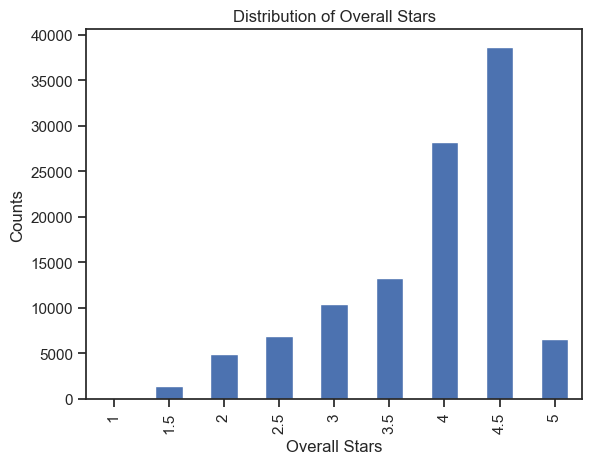

In [212]:
# Create a bar plot of the 'stars' column
stars_counts = filtered_businesses_df['overall_stars'].value_counts().sort_index()
stars_counts.plot(kind='bar')

# Set the Labels
plt.xlabel('Overall Stars')
plt.ylabel('Counts')
plt.title('Distribution of Overall Stars')

# Customize the x-axis tick labels
plt.xticks(range(0,9), ['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5'])

# Display the plot
plt.show()

We plot the distribution of overall stars to see where our data lies in terms of businesses and their overall star rating. We did so in order to get a better understanding of the shape of our data.

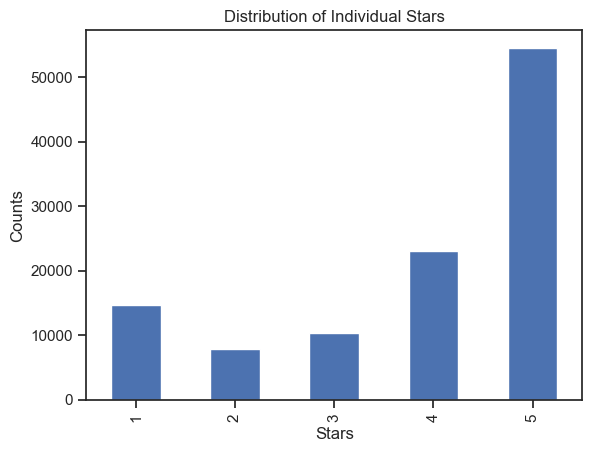

In [213]:
# Create a bar plot of the 'stars' column
stars_counts = filtered_businesses_df['individual_rating'].value_counts().sort_index()
stars_counts.plot(kind='bar')

# Set the Labels
plt.xlabel('Stars')
plt.ylabel('Counts')
plt.title('Distribution of Individual Stars')

# Customize the x-axis tick labels
plt.xticks(range(0,5), ['1', '2', '3', '4', '5'])

# Display the plot
plt.show()

The given distribution of review ratings makes sense, as we can expect many of the individual reviews that are given to be 4 or 5 stars based upon the overall rating for a business.

Moving on, initially, our team started with word clouds in order to identify what words are commonly found in good and bad reviews. This gives us an idea of what keywords to look for in our analysis, and which aspects of the coffee shop may influence people’s reviews. Next, we calculated the frequency of the top 15 keywords in both bad (3 stars or lower) reviews and good (4 or 5 stars) reviews. We will determine how these keywords correlate with the overall rating.

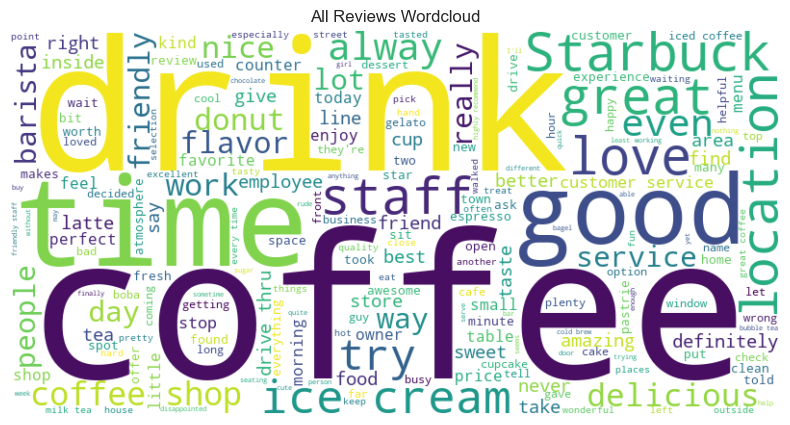

In [214]:
# Assuming the example DataFrame is named "df"
text = ' '.join(filtered_businesses_df['text'])

stopwords_list = ['got', 'think','ordered', 'place', ' one', 'order', 'said', 'maybe', 'asked', 'went', 'restaurant', 'see', 'look', 'husband', 'first time', 'tried',
                  'back', 'usually', 'around', 'visit', 'everyone', 'something', 'first', 'sure', 'stopped', 'walk', 'looking', 'get', 'still',
                  'wanted', 'wish',' want', 'like', 'also', 'going', 'though', 'actually', 'come', 'well', 'grab', 'want', 'probably', 'u', 'seem', 'could',
                  'want', 'know', 'would', 'thing', 'since', 'need', 'make', 'made', 'go', 'however', 'much', 'came', 'ever', 'thought', "I've", 'us', 'wife',
                  'making', "I've ever", 'Thank', 'use', 'Instead', 'Overall', 'one', "I'm"]

nltk_stopwords = set(stopwords.words('english'))

combined_stopwords = nltk_stopwords.union(stopwords_list)


# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=combined_stopwords).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('All Reviews Wordcloud')
plt.show()

After multiple iterations of the word cloud (not shown above), we chose stop words to add to the `stopwords_list` in order to remove them from the word cloud generation. We also used `ntlk` stop words to remove commonly used stop words that may have been used in the reviews. 

After looking at these word clouds, we decided on certain key words to look at, and added them to a key_words list in the next code block.

In [215]:
bad_reviews = filtered_businesses_df.loc[filtered_businesses_df['individual_rating'] <= 3]

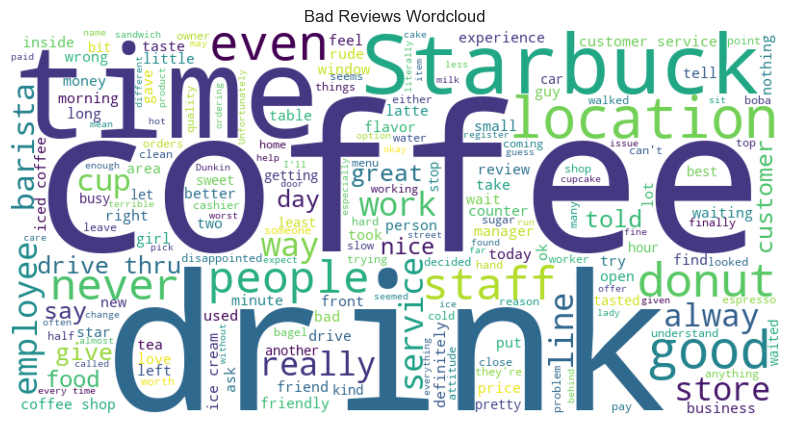

In [216]:
# FOR BAD REVIEWS
text = ' '.join(bad_reviews['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=combined_stopwords).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Bad Reviews Wordcloud')
plt.show()

In [217]:
good_reviews = filtered_businesses_df.loc[filtered_businesses_df['individual_rating'] > 3]

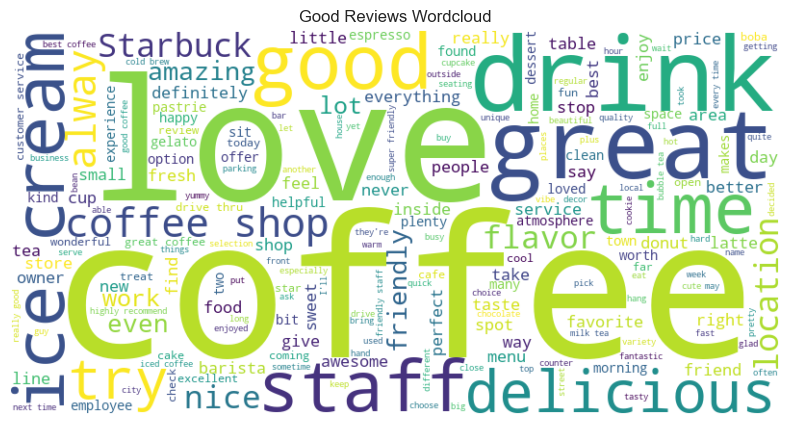

In [218]:
# FOR GOOD REVIEWS
text = ' '.join(good_reviews['text'])
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=combined_stopwords).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Good Reviews Wordcloud')
plt.show()

We generated a word cloud for bad businesses (below or equal to 3 stars) and good businesses (above 3 stars) to see if there is a difference in word frequencies in reviews between businesses that are typically good and bad.

In [219]:
key_words = ['coffee', 'drink', 'time', 'good', 'staff', 'service', 'drive thru', 'area', 'experience', 'location', 'wifi', 'tea', 'taste', 'flavor', 'atmosphere']

keyword_counts = []

for keyword in key_words: 
    counter = 0
    for review in filtered_businesses_df['text']:
        if keyword in review:
            counter += 1
    keyword_counts.append(counter)
            


Using the word clouds generated above, we chose words that we were curious about and generated a bar plot for the count of each word to see an actual count of how many times certain key words were used in reviews.

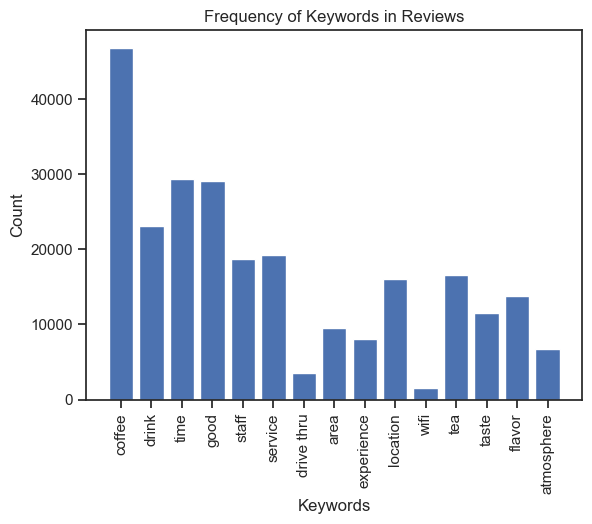

In [220]:
plt.bar(key_words, keyword_counts)
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.title('Frequency of Keywords in Reviews')
plt.xticks(rotation=90)
plt.show()

We also took a look at the top 15 keywords for all reviews, good reviews, and bad reviews. This gives a visual numerical representation of our data, which is more readable.

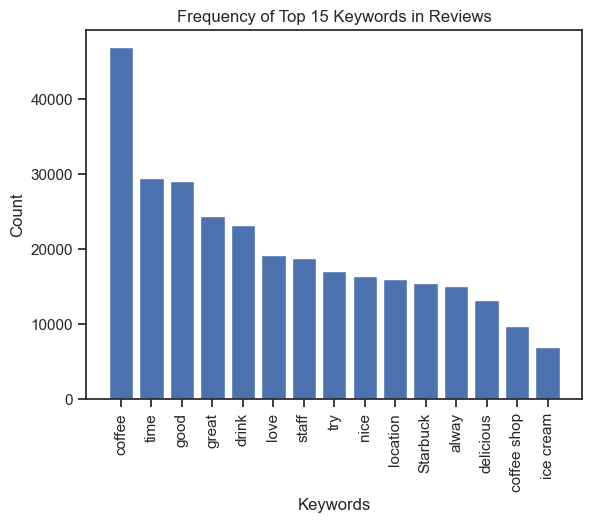

In [221]:
# Get the word frequencies from the word cloud
word_frequencies = wordcloud.words_

# Sort the word frequencies in descending order and select the top 15 words
top_keywords = sorted(word_frequencies, key=word_frequencies.get, reverse=True)[:15]

# Create a list of keyword counts
keyword_counts = []
for keyword in top_keywords:
    counter = 0
    for review in filtered_businesses_df['text']:
        if keyword in review:
            counter += 1
    keyword_counts.append(counter)

sorted_counts, sorted_keywords = zip(*sorted(zip(keyword_counts, top_keywords), reverse=True))


# Plotting the histogram
plt.bar(sorted_keywords, sorted_counts)
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.title('Frequency of Top 15 Keywords in Reviews')
plt.xticks(rotation=90)
plt.show()

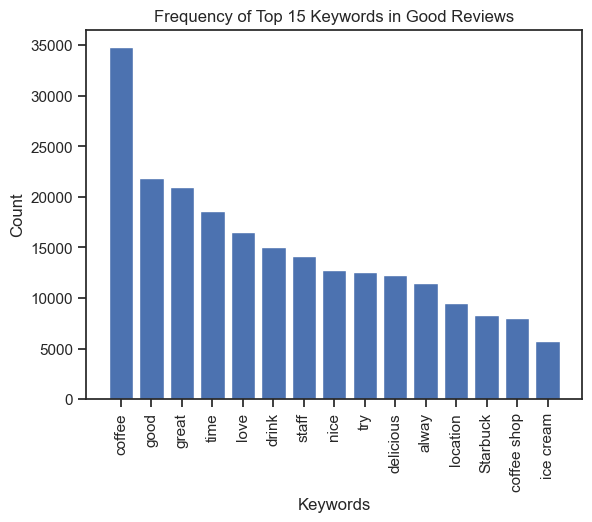

In [222]:

# Create a list of keyword counts
keyword_counts = []
for keyword in top_keywords:
    counter = 0
    for review in good_reviews['text']:
        if keyword in review:
            counter += 1
    keyword_counts.append(counter)

good_sorted_counts, good_sorted_keywords = zip(*sorted(zip(keyword_counts, top_keywords), reverse=True))

# Plotting the histogram
plt.bar(good_sorted_keywords, good_sorted_counts)
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.title('Frequency of Top 15 Keywords in Good Reviews')
plt.xticks(rotation=90)
plt.show()

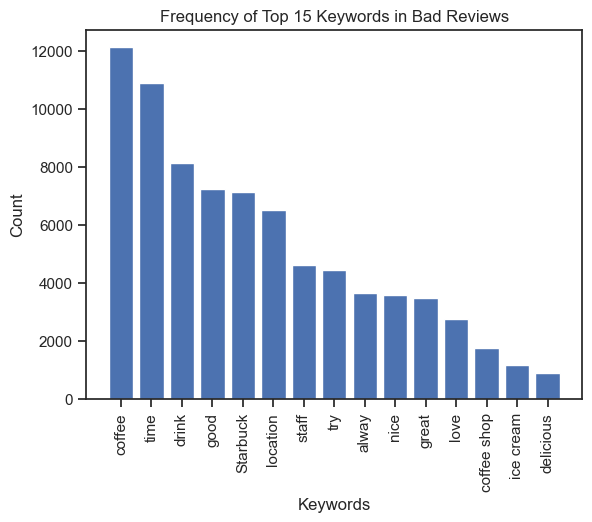

In [223]:

# Create a list of keyword counts
keyword_counts = []
for keyword in top_keywords:
    counter = 0
    for review in bad_reviews['text']:
        if keyword in review:
            counter += 1
    keyword_counts.append(counter)

bad_sorted_counts, bad_sorted_keywords = zip(*sorted(zip(keyword_counts, top_keywords), reverse=True))


# Plotting the histogram
plt.bar(bad_sorted_keywords, bad_sorted_counts)
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.title('Frequency of Top 15 Keywords in Bad Reviews')
plt.xticks(rotation=90)
plt.show()

Lastly, we looked at the average ratings for coffee shops based on keywords found in the reviews for the coffee shop. Something interesting to note here is that coffee shops that mention drive thru's in the reviews are typically rated lower.

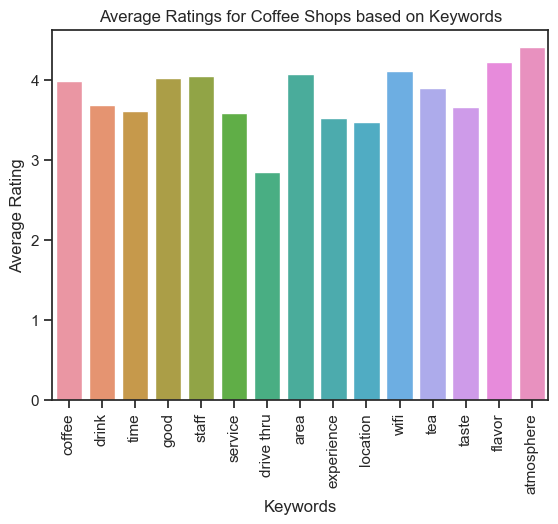

In [224]:
# Calculate the average ratings based on the presence or absence of each keyword
# Filter the DataFrame for coffee shops

# Calculate the average ratings based on the presence or absence of each keyword
keyword_avg_ratings = []
for keyword in key_words:
    keyword_avg_rating = filtered_businesses_df[filtered_businesses_df['text'].str.contains(keyword, case=False)]['individual_rating'].mean()
    keyword_avg_ratings.append(keyword_avg_rating)

# Create a DataFrame to store the average ratings for each keyword
df_avg_ratings = pd.DataFrame({'Keyword': key_words, 'Average Rating': keyword_avg_ratings})

# Plot the average ratings
sns.barplot(data=df_avg_ratings, x='Keyword', y='Average Rating')
plt.xlabel('Keywords')
plt.ylabel('Average Rating')
plt.title('Average Ratings for Coffee Shops based on Keywords')
plt.xticks(rotation=90)
plt.show()





In [225]:
# filtered_businesses_df.to_csv("filtered_businesses_and_reviews.csv")

Next, based on what we, as students, look for in coffee shops, we identified several attributes to analyze from the information that was provided in the data set. These include noise level, wifi, parking, and outdoor seating. For parking, we considered having garage or lot parking as easy parking (True), while not having those would be considered difficult parking (False).


**Noise Level:**

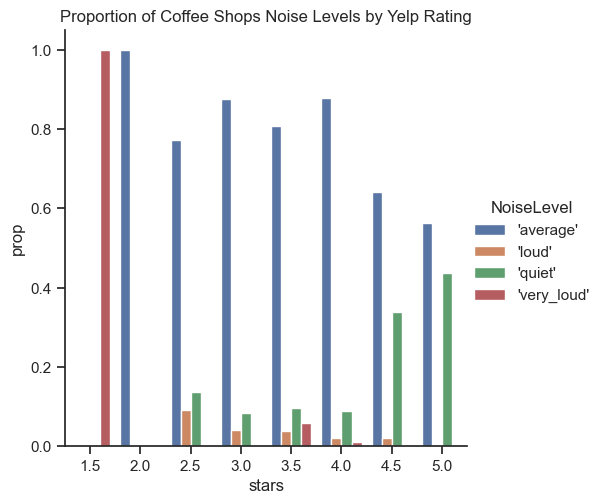

In [226]:
def label_prop_NoiseLevel(input):
    return float(gb_attributes_NoiseLevel[input[0]][input[1]])
    
gb_attributes_NoiseLevel = df_yelp_attributes.groupby(['stars', "NoiseLevel"])["NoiseLevel"].count().unstack("stars").fillna(0)
gb_attributes_NoiseLevel = np.transpose(gb_attributes_NoiseLevel.div(gb_attributes_NoiseLevel.sum()))
# # df2.head()

prop_NoiseLevel = df_yelp_attributes[[ "NoiseLevel", "stars"]].dropna().drop_duplicates()
prop_NoiseLevel["prop"] = prop_NoiseLevel.apply(label_prop_NoiseLevel, axis=1)

prop_NoiseLevel = prop_NoiseLevel.sort_values("NoiseLevel").reset_index(drop=True)
prop_NoiseLevel.head()

sns.catplot(data = prop_NoiseLevel, kind = "bar", x="stars", y="prop", hue="NoiseLevel").set(title = "Proportion of Coffee Shops Noise Levels by Yelp Rating")



From graphing our attributes against the store ratings, we noticed several interesting trends. Coffee shops with higher noise levels had lower ratings than coffee shops with lower noise levels. Higher noise levels may correlate with the shop being more crowded, which would result in a less pleasant experience for customers.

**WiFi:**

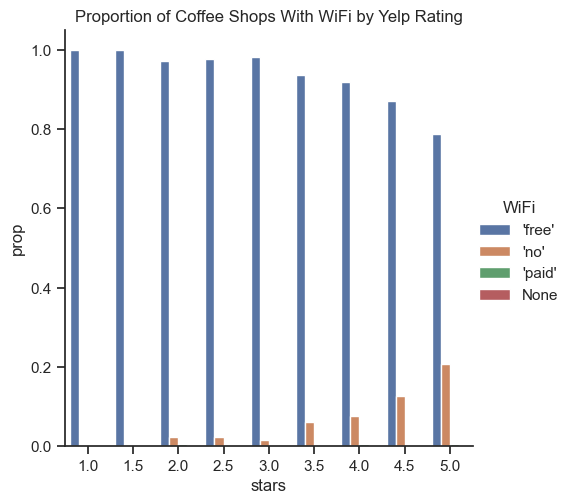

In [227]:
def label_prop_WiFi(input):
    return float(gb_attributes_WiFi[input[0]][input[1]])
gb_attributes_WiFi = df_yelp_attributes.groupby(['stars', "WiFi"])["WiFi"].count().unstack("stars").fillna(0)
gb_attributes_WiFi = np.transpose(gb_attributes_WiFi.div(gb_attributes_WiFi.sum()))

prop_WiFi = df_yelp_attributes[[ "WiFi", "stars"]].dropna().drop_duplicates()
prop_WiFi["prop"] = prop_WiFi.apply(label_prop_WiFi, axis=1)

prop_WiFi = prop_WiFi.sort_values("WiFi").reset_index(drop=True)
prop_WiFi.head()

sns.catplot(data = prop_WiFi, kind = "bar", x="stars", y="prop", hue="WiFi").set(title = "Proportion of Coffee Shops With WiFi by Yelp Rating")

 This may also relate to another trend that we noticed, which was that coffee shops with higher ratings were more likely to have no wifi, compared to lower rated coffee shops, which almost always have free wifi. This trend could be related to the fact that coffee shops that have free wifi would tend to have more people studying and taking up space there, which could lower the rating due to it being crowded. 

**Outdoor Seating**

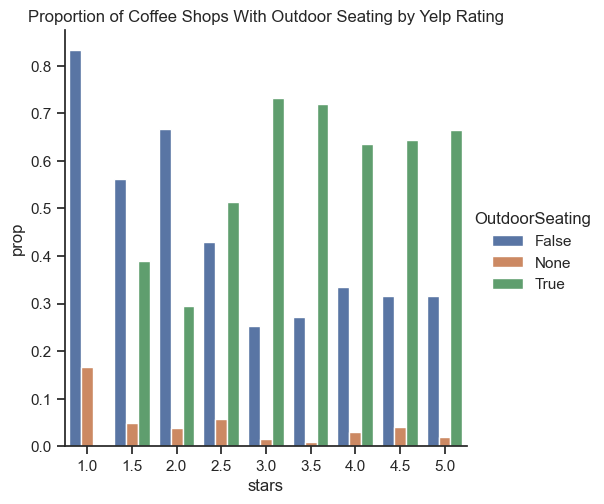

In [228]:
def label_prop_OutdoorSeating(input):
    return float(gb_attributes_OutdoorSeating[input[0]][input[1]])
gb_attributes_OutdoorSeating = df_yelp_attributes.groupby(['stars', "OutdoorSeating"])["OutdoorSeating"].count().unstack("stars").fillna(0)
gb_attributes_OutdoorSeating = np.transpose(gb_attributes_OutdoorSeating.div(gb_attributes_OutdoorSeating.sum()))


prop_OutdoorSeating = df_yelp_attributes[[ "OutdoorSeating", "stars"]].dropna().drop_duplicates()
prop_OutdoorSeating["prop"] = prop_OutdoorSeating.apply(label_prop_OutdoorSeating, axis=1)

prop_OutdoorSeating = prop_OutdoorSeating.sort_values("OutdoorSeating").reset_index(drop=True)
prop_OutdoorSeating.head()

sns.catplot(data = prop_OutdoorSeating, kind = "bar", x="stars", y="prop", hue="OutdoorSeating").set(title = "Proportion of Coffee Shops With Outdoor Seating by Yelp Rating")

Additionally, coffee shops without outdoor seating are typically rated lower. In our graph, none of the stores with 1 star have outdoor seating, while at least .6 of all shops with 4 stars or above have outdoor seating. This suggests that there is a correlation between having outdoor seating and having a higher rating.

**Business Parking**

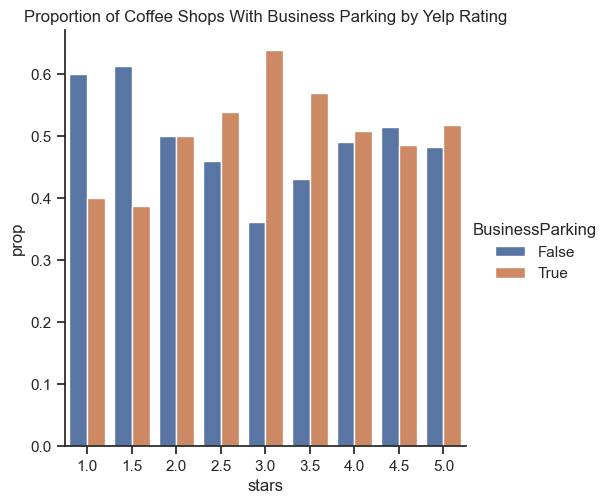

In [229]:
def label_prop_BusinessParking(input):
    return float(gb_attributes_BusinessParking[input[0]][input[1]])

gb_attributes_BusinessParking = df_yelp_attributes.groupby(['stars', "BusinessParking"])["BusinessParking"].count().unstack("stars").fillna(0)
gb_attributes_BusinessParking = np.transpose(gb_attributes_BusinessParking.div(gb_attributes_BusinessParking.sum()))
# # df2.head()

prop_BusinessParking = df_yelp_attributes[[ "BusinessParking", "stars"]].dropna().drop_duplicates()
prop_BusinessParking["prop"] = prop_BusinessParking.apply(label_prop_BusinessParking, axis=1)

prop_BusinessParking = prop_BusinessParking.sort_values("BusinessParking").reset_index(drop=True)
prop_BusinessParking.head()

sns.catplot(data = prop_BusinessParking, kind = "bar", x="stars", y="prop", hue="BusinessParking").set(title = "Proportion of Coffee Shops With Business Parking by Yelp Rating")

However, on the other hand, it appears that easy parking is not a large influence on the overall shop rating. Although the coffee shops with 1 or 1.5 star ratings are less likely to have easy parking, coffee shops with 4 or 5 stars have no significant difference between easy and difficult parking.


**Weekend Availability**

In [230]:
# Convert string to dictionary
filtered_businesses_df["hours"] = filtered_businesses_df["hours"].apply(eval)

# Checking if business is open on a certain day
def open_on_day(time_str: str) -> True:
    op, close = time_str.split('-')
    if op[0] != '0' and close[0] != '0':
        return True
    return False

# Check if business is open weekends
def open_weekends(hours_dict: dict):
    if 'Sunday' not in hours_dict or 'Saturday' not in hours_dict:
        return False
    return open_on_day(hours_dict['Sunday']) and open_on_day(hours_dict['Saturday'])

# Create a new column that holds True if business is open weekends
filtered_businesses_df["open_weekends"] = filtered_businesses_df["hours"].apply(open_weekends)

filtered_businesses_df.head()

,Unnamed: 0,business_id,individual_rating,text,name,overall_stars,review_count,is_open,attributes,categories,hours,WiFi,BusinessParking,NoiseLevel,OutdoorSeating,open_weekends
0,4398,8xM8akbQhHDQdJO1sPMB1A,5,I had the pleasure to meet with Ann today and ...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None,True
1,4399,8xM8akbQhHDQdJO1sPMB1A,5,I felt the need to add a rating to their only ...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None,True
2,4400,8xM8akbQhHDQdJO1sPMB1A,5,Have driven past this sharp looking java shop ...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None,True
3,4401,8xM8akbQhHDQdJO1sPMB1A,3,My review is based on the fact that I don't li...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None,True
4,4402,8xM8akbQhHDQdJO1sPMB1A,5,Great quality atmosphere and excellent tasting...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None,True


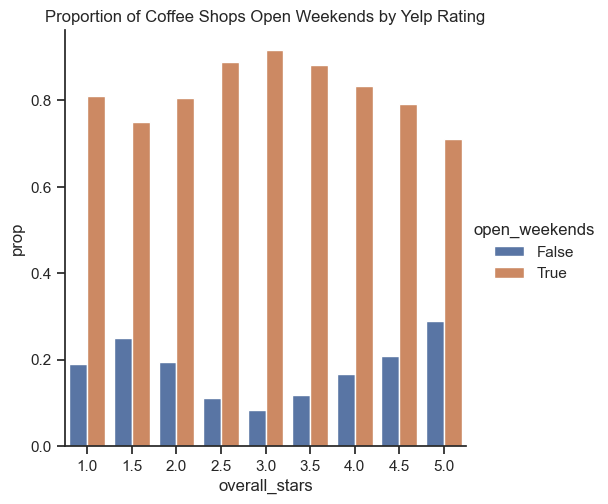

In [231]:
def label_prop_OpenWeekends(input):
    return float(gb_attributes_OpenWeekends[input[0]][input[1]])

gb_attributes_OpenWeekends = filtered_businesses_df.groupby(['overall_stars', "open_weekends"])["open_weekends"].count().unstack("overall_stars").fillna(0)
gb_attributes_OpenWeekends = np.transpose(gb_attributes_OpenWeekends.div(gb_attributes_OpenWeekends.sum()))
# # df2.head()

prop_OpenWeekends = filtered_businesses_df[[ "open_weekends", "overall_stars"]].dropna().drop_duplicates()
prop_OpenWeekends["prop"] = prop_OpenWeekends.apply(label_prop_OpenWeekends, axis=1)

prop_OpenWeekends = prop_OpenWeekends.sort_values("open_weekends").reset_index(drop=True)
prop_OpenWeekends.head()

sns.catplot(data = prop_OpenWeekends, kind = "bar", x="overall_stars", y="prop", hue="open_weekends").set(title = "Proportion of Coffee Shops Open Weekends by Yelp Rating")

Here, we introduce another factor, which is whether or not the business is open on the weekends. We do so by running through the dictionary to determine whether Saturday and Sunday are located in the hours information. If so, it is initialized into a new column as True and if not, False. We then plotted the column against business ratings, which gave us the above graph. Interestingly enough, we see a pattern where low (1-2) and high (4-5) star stores are less likely to be open on the weekends, while stores around 3 stars are more likely to be open on weekends. 

**Outlet Availability**

In [266]:
import re

# Assuming you have a pandas DataFrame named 'df' with a column named 'text'

# Define lists of keywords indicating the presence or absence of an outlet
outlet_keywords = ['outlet', 'power outlet', 'electric outlet']
no_outlet_keywords = ['no outlet', 'no power outlet', 'no electric outlet']

# Create a new column 'outlet' and initialize it with 'not mentioned'
filtered_businesses_df['outlet'] = 'not mentioned'

# Iterate over each review in the 'text' column
for i, review in enumerate(filtered_businesses_df['text']):
    # Convert the review to lowercase for case-insensitive matching
    review_lower = review.lower()
    
    # Search for mentions of having an outlet using the outlet keywords
    has_outlet = any(keyword in review_lower for keyword in outlet_keywords)
    
    # Search for mentions of not having an outlet using the no outlet keywords
    has_no_outlet = any(keyword in review_lower for keyword in no_outlet_keywords)
    
    # Update the 'outlet' column based on the presence or absence of an outlet
    if has_outlet:
        filtered_businesses_df.loc[i, 'outlet'] = 'yes'
    elif has_no_outlet:
        filtered_businesses_df.loc[i, 'outlet'] = 'no'

filtered_businesses_df['outlet'].head(7)

0    not mentioned
1    not mentioned
2    not mentioned
3    not mentioned
4    not mentioned
5    not mentioned
6    not mentioned
Name: outlet, dtype: object

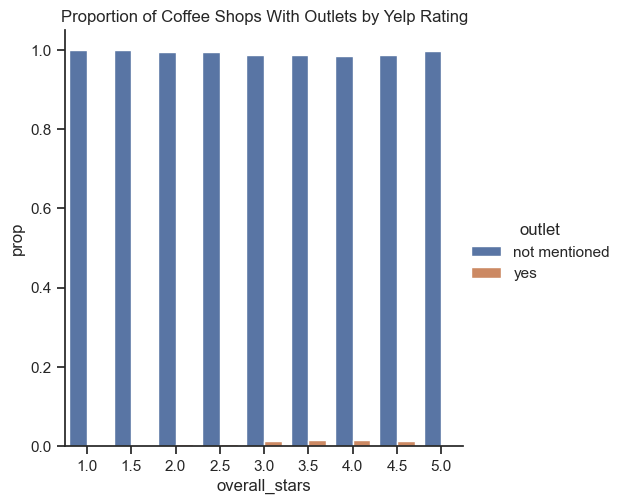

In [233]:
def label_prop_Outlets(input):
    return float(gb_attributes_Outlets[input[0]][input[1]])

gb_attributes_Outlets = filtered_businesses_df.groupby(['overall_stars', "outlet"])["outlet"].count().unstack("overall_stars").fillna(0)
gb_attributes_Outlets = np.transpose(gb_attributes_Outlets.div(gb_attributes_Outlets.sum()))
# # df2.head()

prop_Outlets = filtered_businesses_df[[ "outlet", "overall_stars"]].dropna().drop_duplicates()
prop_Outlets["prop"] = prop_Outlets.apply(label_prop_Outlets, axis=1)

prop_Outlets = prop_Outlets.sort_values("outlet").reset_index(drop=True)
prop_Outlets.head()

sns.catplot(data = prop_Outlets, kind = "bar", x="overall_stars", y="prop", hue="outlet").set(title = "Proportion of Coffee Shops With Outlets by Yelp Rating")

The last factor we wanted to look at was whether or not the coffee shop had outlets. In order to do this, we iterated through all of the reviews for a business, and used phrases such as ‘power outlet’ or ‘no power outlet’ to create a new column that describes whether the business has power outlets or not.

In [234]:

# Assuming you have a DataFrame called 'reviews_df' with 'text' column for reviews and 'rating' column for ratings

# Preprocess text data and create word count features
vectorizer = CountVectorizer(stop_words=list(combined_stopwords))
X = vectorizer.fit_transform(filtered_businesses_df['text'])
y = filtered_businesses_df['overall_stars']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r_squared = model.score(X_test, y_test)

print("Mean Squared Error:", mse)
print("R-squared:", r_squared)


/Users/kylealvarez/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['instead', 'overall', 'thank', 'time'] not in stop_words.
  warnings.warn(


Mean Squared Error: 1.1688584037452483
R-squared: -0.7658328778250676


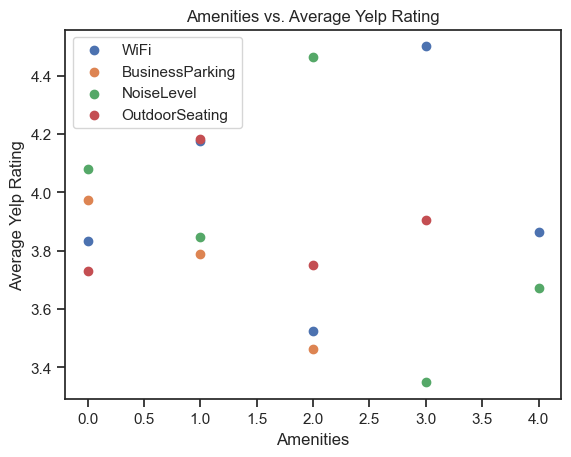

In [236]:
import matplotlib.pyplot as plt

# Select the amenities and average Yelp rating columns
amenities = ['WiFi', 'BusinessParking', 'NoiseLevel', 'OutdoorSeating']
average_yelp_rating = 'overall_stars'

# Filter the DataFrame to include only the necessary columns
filtered_df = filtered_businesses_df[amenities + [average_yelp_rating]].copy()

# Assign numerical values to represent the 'Not Specified' category in each amenity column
for amenity in amenities:
    filtered_df[amenity] = filtered_df[amenity].fillna('Not Specified')
    filtered_df[amenity] = pd.Categorical(filtered_df[amenity])
    filtered_df[amenity] = filtered_df[amenity].cat.codes

# Iterate over each amenity column and create a scatter plot
for amenity in amenities:
    # Group the data by the amenity and calculate the mean Yelp rating for each amenity value
    grouped_data = filtered_df.groupby(amenity)[average_yelp_rating].mean()
    
    # Create the scatter plot
    plt.scatter(grouped_data.index, grouped_data.values, label=amenity)

# Add labels and title to the plot
plt.xlabel('Amenities')
plt.ylabel('Average Yelp Rating')
plt.title('Amenities vs. Average Yelp Rating')
plt.legend()

# Display the plot
plt.show()


This graph compares the number of Amenities that a coffee shop has out of the four we just looked at above. Overall there is not a strong trend to be seen in this scatter plot, but we do see that the extremely highly rated (4.4 ratings and above) have at least two of the four amenities graphed above. For the rest of the ratings, the points are scattered pretty randomly.

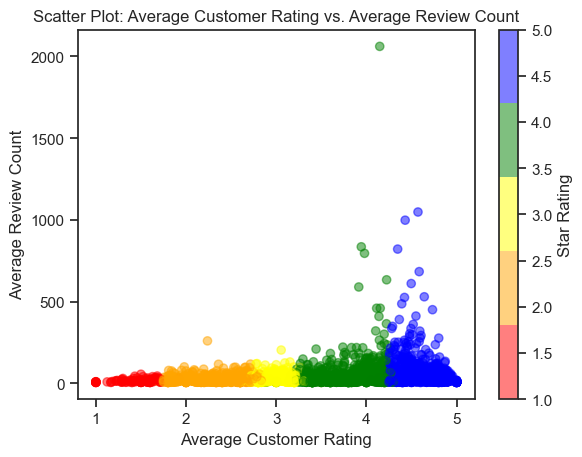

In [237]:


# Aggregate the data by calculating average customer rating and review count per coffee shop
aggregated_data = filtered_businesses_df.groupby('business_id').agg({
    'individual_rating': 'mean',
    'review_count': 'mean',
    'overall_stars': 'first'  # Assuming the overall stars column has the same value for each coffee shop
}).reset_index()

# Map star ratings to colors
star_colors = {
    1: 'red',
    2: 'orange',
    3: 'yellow',
    4: 'green',
    5: 'blue'
}

# Convert star ratings to RGBA values
rgba_colors = [mcolors.to_rgba(color) for color in star_colors.values()]

# Create the scatter plot with colored points
plt.scatter(
    aggregated_data['individual_rating'],
    aggregated_data['review_count'],
    c=aggregated_data['overall_stars'],
    cmap=mcolors.ListedColormap(rgba_colors),
    alpha=0.5
)

# Add a colorbar to show the legend for star ratings
cbar = plt.colorbar()
cbar.set_label('Star Rating')

plt.xlabel('Average Customer Rating')
plt.ylabel('Average Review Count')
plt.title('Scatter Plot: Average Customer Rating vs. Average Review Count')
plt.show()


This graph shows the average review count against the average customer rating for coffee shops. We can see that there are many businesses that have an average review count of under 500, and there is a wide spread of 1-5 customer ratings for these coffee shops.. However we do note that there are a handful of coffee shops between the 4 and 5 average customer rating that have an average review count above 500. We can interpret this graph to understand that there are a lot of coffee shops in our dataset that have above average reviews and a lot of customers rating these coffee shops. On the other hand, there's not many poorly rated coffee shops with many reviews.

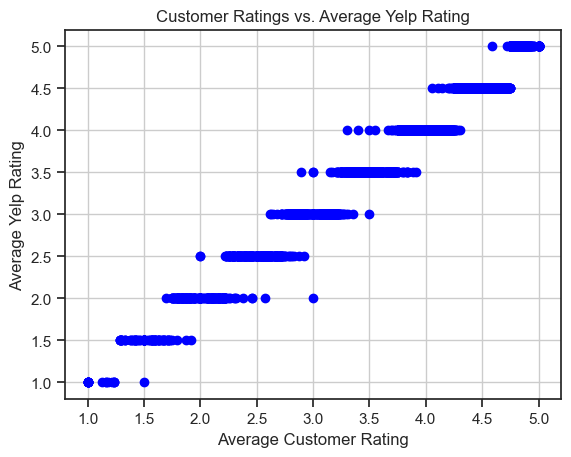

In [238]:
# Calculate average customer rating for each coffee shop
average_customer_ratings = filtered_businesses_df.groupby('business_id')['individual_rating'].mean()

# Create a new dataframe with average customer ratings and average Yelp ratings
coffee_shop_ratings = pd.DataFrame({
    'Average Customer Rating': average_customer_ratings,
    'Average Yelp Rating': filtered_businesses_df.groupby('business_id')['overall_stars'].mean()
})

# Plotting Customer Ratings vs. Average Yelp Rating
plt.scatter(coffee_shop_ratings['Average Customer Rating'], coffee_shop_ratings['Average Yelp Rating'], color='blue')
plt.xlabel('Average Customer Rating')
plt.ylabel('Average Yelp Rating')
plt.title('Customer Ratings vs. Average Yelp Rating')
plt.grid(True)
plt.show()


For this graph, we are plotting the average customer rating versus the average yelp rating. We can see this trend of an average yelp rating for each respecting rating to have a standard deviation of about 1 star which makes sense when interpreting the rating for a business and average rating. For example, when looking at a 5 star coffee shop, we can expect the average customer rating to be above 4.5 star and 5 star. This is more of a validation towards our data in understanding the spread of reviews for coffee shops. However there are interesting points to note when looking at this. We should expect the average customer rating and the overall yelp rating to converge on the same point, especially for lower review counts of a coffee shop, however, for example, for one coffee shop we are seeing an average customer rating of a 3.0, but the overall rating for a coffee shop is 2.0.

In [239]:
# Select the relevant columns for correlation analysis
correlation_columns = ['individual_rating', 'overall_stars', 'review_count']

# Create a new dataframe with the selected columns
correlation_df = filtered_businesses_df[correlation_columns]

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Display the correlation matrix
print(correlation_matrix)


                   individual_rating  overall_stars  review_count
individual_rating           1.000000       0.551411      0.127653
overall_stars               0.551411       1.000000      0.200968
review_count                0.127653       0.200968      1.000000


These next steps of the code are creating a new column for the dataframe in which we are congregating every single customer review and rating into a dictionary in which we will have a final dataframe of just every unique business and a column that stores a dictionary of it's customer reviews and ratings. We do this in order to reduce the amount of duplicate businesses in our dataset that may skew our data as there may be a business that is 5 stars and a lot of customer reviews, which would lead to a skew in averaging.

In [259]:
# Define a function to create a list of dictionaries for each business
def create_reviews_list(group):
    reviews_list = []
    for idx, row in group.iterrows():
        review_dict = {'individual_rating': row['individual_rating'], 'text': row['text']}
        reviews_list.append(review_dict)
    return reviews_list

# Group the DataFrame by 'business_id' and apply the create_reviews_list function
cleaned_df = filtered_businesses_df.groupby('business_id').apply(create_reviews_list).reset_index(name='reviews')

# Print the cleaned DataFrame
cleaned_df


,business_id,reviews
0,-0gRYq5UjMtZbELj0KHxzA,"[{'individual_rating': 4, 'text': 'I love La C..."
1,-34c4hcDPIInTROr8Xtxtw,"[{'individual_rating': 4, 'text': 'Gelato-Go H..."
2,-3dkEoYgH8AlUtBMZvzUfg,"[{'individual_rating': 1, 'text': 'Had the wor..."
3,-6kIZWnXPuDC6JiQJ-A1fg,"[{'individual_rating': 1, 'text': 'This is by ..."
4,-85kJMtb9wqNWDT8yLbitw,"[{'individual_rating': 5, 'text': 'Awsome coff..."
...,...,...
2514,zjhcbO-fhczQwZwfvchm0A,"[{'individual_rating': 1, 'text': 'Horrible se..."
2515,zpPeS4x_9EFBobT_OHipQQ,"[{'individual_rating': 5, 'text': 'They make t..."
2516,zqAPDoI34MDtNjvCWe3WKA,"[{'individual_rating': 1, 'text': 'I visit thi..."
2517,ztcOE7NN0WdleNOCbje8ng,"[{'individual_rating': 3, 'text': 'I appreciat..."


In [243]:
# Group the cleaned DataFrame by 'business_id' and aggregate the reviews into a list
aggregated_reviews = cleaned_df.groupby('business_id')['reviews'].apply(list).reset_index()

# Merge the aggregated reviews with the old dataset on 'business_id'
merged_df = filtered_businesses_df.merge(aggregated_reviews, on='business_id', how='left')

# Print the merged DataFrame
merged_df


,Unnamed: 0,business_id,individual_rating,text,name,overall_stars,review_count,is_open,attributes,categories,hours,WiFi,BusinessParking,NoiseLevel,OutdoorSeating,open_weekends,outlet,reviews
0,4398,8xM8akbQhHDQdJO1sPMB1A,5,I had the pleasure to meet with Ann today and ...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None,True,not mentioned,"[[{'individual_rating': 5, 'text': 'I had the ..."
1,4399,8xM8akbQhHDQdJO1sPMB1A,5,I felt the need to add a rating to their only ...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None,True,not mentioned,"[[{'individual_rating': 5, 'text': 'I had the ..."
2,4400,8xM8akbQhHDQdJO1sPMB1A,5,Have driven past this sharp looking java shop ...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None,True,not mentioned,"[[{'individual_rating': 5, 'text': 'I had the ..."
3,4401,8xM8akbQhHDQdJO1sPMB1A,3,My review is based on the fact that I don't li...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None,True,not mentioned,"[[{'individual_rating': 5, 'text': 'I had the ..."
4,4402,8xM8akbQhHDQdJO1sPMB1A,5,Great quality atmosphere and excellent tasting...,Black Rock Coffee Bar,4.5,7,1,"{'WiFi': ''free'', 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '...",'free',None,None,None,True,not mentioned,"[[{'individual_rating': 5, 'text': 'I had the ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110567,432364,vln582yf0nbUuHzBnY6yOQ,5,This place is definitely worth going too!!\nHu...,Chill Cawfee Riverview,5.0,13,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Food, Coffee & Tea","{'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'...",None,None,None,None,True,not mentioned,"[[{'individual_rating': 5, 'text': 'Great plac..."
110568,432365,vln582yf0nbUuHzBnY6yOQ,5,Great vibe and wonderfully nice barista! The c...,Chill Cawfee Riverview,5.0,13,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Food, Coffee & Tea","{'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'...",None,None,None,None,True,not mentioned,"[[{'individual_rating': 5, 'text': 'Great plac..."
110569,432366,vln582yf0nbUuHzBnY6yOQ,5,Two dudes working there were cool. Helped wit...,Chill Cawfee Riverview,5.0,13,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Food, Coffee & Tea","{'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'...",None,None,None,None,True,not mentioned,"[[{'individual_rating': 5, 'text': 'Great plac..."
110570,432367,vln582yf0nbUuHzBnY6yOQ,5,"Came for the grand opening, tried the nitro co...",Chill Cawfee Riverview,5.0,13,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Food, Coffee & Tea","{'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'...",None,None,None,None,True,not mentioned,"[[{'individual_rating': 5, 'text': 'Great plac..."


In [244]:

# Clean the dataset to keep only unique businesses
cleaned_df = merged_df.drop_duplicates(subset='business_id')

# Print the cleaned DataFrame
cleaned_df = cleaned_df.drop(['individual_rating', 'text'], axis=1)

cleaned_df['reviews'][0]


[[{'individual_rating': 5,
   'text': 'I had the pleasure to meet with Ann today and not only was she extremely helpful and so positive, she went above and beyond to make my 1st experience here amazing and made it a absolute regular customer from this day forward. Thanks girlie!!'},
  {'individual_rating': 5,
   'text': "I felt the need to add a rating to their only 5 reviews so far  this Black Rock is better than any of the locations I've been to in Oregon and Idaho. (I've been to too many...) I was almost embarrassed at first to be one of those people that they knew my order when I pulled up. I'm no longer embarrassed, but impressed and honored to know these people! \n\nThe customer service is above and beyond here. Besides learning my order extremely quick, I had a great experience this week. I was in the drive thru, and a customer came inside the store. She was fairly distracting to the Black Rock employees, demanding of their time and honestly just rude. They were very patient and

**Average Ratings for each Amenity**

In this section, we went through each amenity and calculated the average Yelp rating per amenity. For instance, the average Yelp rating of all coffee shops that have free WiFi is 3.52, while the average Yelp rating of all coffee shops that have no WiFi is 4.19.

In [246]:

# Extract the amenities from the attributes column
cleaned_df['amenities'] = cleaned_df['attributes'].apply(lambda x: x.get('WiFi'))  # Replace 'WiFi' with the desired amenity

# Group the data by amenity and calculate the average rating for each amenity
average_ratings = cleaned_df.groupby('amenities')['overall_stars'].mean()

# Print the average ratings for each amenity
for amenity, rating in average_ratings.items():
    print(f"Amenity: {amenity}, Average Rating: {rating}")


Amenity: 'free', Average Rating: 3.5207811717576365
Amenity: 'no', Average Rating: 4.185534591194968
Amenity: 'paid', Average Rating: 3.7
Amenity: None, Average Rating: 4.5


In [247]:
cleaned_df['amenities'] = cleaned_df['attributes'].apply(lambda x: x.get('NoiseLevel'))  # Replace 'WiFi' with the desired amenity

# Group the data by amenity and calculate the average rating for each amenity
average_ratings = cleaned_df.groupby('amenities')['overall_stars'].mean()

# Print the average ratings for each amenity
for amenity, rating in average_ratings.items():
    print(f"Amenity: {amenity}, Average Rating: {rating}")

Amenity: 'average', Average Rating: 3.8624161073825505
Amenity: 'loud', Average Rating: 3.590909090909091
Amenity: 'quiet', Average Rating: 4.329268292682927
Amenity: 'very_loud', Average Rating: 3.2


In [248]:
cleaned_df['amenities'] = cleaned_df['outlet'] # Replace 'WiFi' with the desired amenity

# Group the data by amenity and calculate the average rating for each amenity
average_ratings = cleaned_df.groupby('amenities')['overall_stars'].mean()

# Print the average ratings for each amenity
for amenity, rating in average_ratings.items():
    print(f"Amenity: {amenity}, Average Rating: {rating}")

Amenity: not mentioned, Average Rating: 3.539031224979984
Amenity: yes, Average Rating: 3.6666666666666665


In [249]:
cleaned_df['amenities'] = cleaned_df['OutdoorSeating'] # Replace 'WiFi' with the desired amenity

# Group the data by amenity and calculate the average rating for each amenity
average_ratings = cleaned_df.groupby('amenities')['overall_stars'].mean()

# Print the average ratings for each amenity
for amenity, rating in average_ratings.items():
    print(f"Amenity: {amenity}, Average Rating: {rating}")

Amenity: False, Average Rating: 3.42201166180758
Amenity: None, Average Rating: 3.483050847457627
Amenity: True, Average Rating: 3.7107201309328968


In [258]:
filtered_businesses_df['amenities'] = filtered_businesses_df['open_weekends'] # Replace 'WiFi' with the desired amenity

# Group the data by amenity and calculate the average rating for each amenity
average_ratings = filtered_businesses_df.groupby('amenities')['overall_stars'].mean()

# Print the average ratings for each amenity
for amenity, rating in average_ratings.items():
    print(f"Amenity: {amenity}, Average Rating: {rating}")

Amenity: False, Average Rating: 4.015559140344487
Amenity: True, Average Rating: 3.829429150019156


# Conclusion & Discussion

From our analysis, we found that noise level was the most influential factor on overall Yelp rating. The ‘quiet’ noise level had the highest likelihood of being rating high (4.33). This makes sense, as a quiet noise level may result in a more calming ambiance, resulting in a better customer experience. 

Close behind was WiFi availability, which was also influential. However, this manifested in a way that contradicted our hypothesis. A business having no WiFi correlated with a high likelihood of being rated high (4.19) No WiFi also being an indicator of a high rating was interesting for us because that goes against our hypothesis. We thought that, since we typically look for coffee shops with WiFi to do work at, that would correlate with a higher rating. However, this may not reflect the typical Yelp user’s experience. In contrast, we think it's possible that having no WiFi may encourage patrons to engage more with other patrons, resulting in a more positive experience. It may also prevent customers from loitering/taking up space while doing work, which may result in less crowding and a quieter noise level.

While these two factors may have a significant impact on coffee shop ratings, it is important to note that the interaction between factors is likely what determines the coffee shop’s final rating. We believe that looking at how different factors intersect and how they influence Yelp ratings would allow us to make more informed decisions on what factors lead to a specific Yelp rating.

In future iterations of our project, we hope to conduct more in-depth sentiment analysis on the reviews in order to get a more accurate representation of if a coffee shop has a specific amenity. By doing so, we would be able to consider factors such as service or coffee quality. We would also be able to consider more extreme reviews and code them accordingly. It would also be interesting to factor in geographical location into our analysis, and see if specific locations correlate with specific ratings. For example, visualizing the difference in ratings between a coffee shop located in a downtown area vs a mall, if such a difference exists.
